In [1]:
library(ape)
library(jsonlite)
library(sitePath)
suppressPackageStartupMessages(library(trackViewer))

DATA_DIR <- "Data"
PLOTS_DIR <- "Output"

PROTEIN_DOMAIN = list(
    "S" = list(
        "RBD" = 319:541,
        "NTD" = 13:303,
        "S2" = 686:1273,
        "Fusion peptide" = 816:855,
        "HR1" = 920:970,
        "HR2" = 1163:1202
    )
)

SITES_COLOR <- c(
    "fixation" = "gold",
    "parallel" = "lightblue", 
    "paraFix" = "red"
)
DOMAIN_COLOR <- c(
#     "NTD" = "#8C95A3",
#     "RBD" = "#845856",
#     "S2" = "#7D8A73",
#     "Seq" = "#DBD9DA",
    "Seq" = "black",
    "NTD" = "blue",
    "RBD" = "magenta",
    "S2" = "green",
    "Fusion peptide" = "orange",
    "HR1" = "purple",
    "HR2" = "purple"
)

In [2]:
my.plotFeatures <- function(feature.splited, LINEH, bottomHeight, 
                         label_on_feature=FALSE){
    feature.height <- 0
    for(n in seq_along(feature.splited)){
        this.feature.height <- 
            max(c(feature.splited[[n]]$height/2, 
                  .0001)) + 0.2 * LINEH
        feature.height <- feature.height + this.feature.height
        ##baseline
        grid.lines(x=c(0, 1), y=c(bottomHeight+feature.height, 
                                  bottomHeight+feature.height))
        for(m in seq_along(feature.splited[[n]])){
            this.dat <- feature.splited[[n]][m]
            color <- if(is.list(this.dat$color)) this.dat$color[[1]] else 
                this.dat$color
            if(length(color)==0) color <- "black"
            fill <- if(is.list(this.dat$fill)) this.dat$fill[[1]] else 
                this.dat$fill
            if(length(fill)==0) fill <- "white"
            this.cex <- if(length(this.dat$cex)>0) this.dat$cex[[1]][1] else 1
            lwd <- if(length(this.dat$lwd)>0) this.dat$lwd[[1]][1] else 1
            this.feature.height.m <- 
                if(length(this.dat$height)>0) 
                    this.dat$height[[1]][1] else 
                        2*this.feature.height
            grid.roundrect(x=start(this.dat)-.1, y=bottomHeight+feature.height, 
                      width=width(this.dat)-.8, 
                      height=this.feature.height.m,
                      just="left", gp=gpar(col=color, fill=fill, lwd=lwd), 
                      default.units = "native", r=unit(0.2, "snpc"))
            if(label_on_feature & !is.na(names(this.dat)[1])){
              grid.text(x=(start(this.dat)+end(this.dat))/2, 
                        y=bottomHeight+feature.height,
                        just = "centre",
                        label = names(this.dat)[1],
                        gp= gpar(list(cex=this.cex * 
                                        this.feature.height.m/
                                        this.feature.height,
                                      color=color)), 
                        default.units = "native")
            }
        }
        feature.height <- feature.height + this.feature.height
    }
    feature.height
}

assignInNamespace(x="plotFeatures", value=my.plotFeatures, ns=asNamespace("trackViewer"))

In [3]:
domain4Lolli <- function(domains, seqLen) {
    domainHeight <- 0.1
    seqHelight <- 0.02
    res <- list()
    
    blockStarts <- c(0)
    blockEnds <- c(seqLen)
    blockNames <- c("Seq")
    blockHeights <- c(seqHelight)

    for (domainName in names(domains)) {
        domainSites <- sort(domains[[domainName]])
        site <- domainSites[1]
        cSites <- c(site, site + 1)

        blockStarts <- c(blockStarts, site)
        blockEnd <- site + 1
        blockNames <- c(blockNames, domainName)
        blockHeights <- c(blockHeights, domainHeight)

        pSites <- cSites

        for (site in domainSites[-1]) {
            cSites <- c(site - 1, site, site + 1)
            if (length(intersect(pSites, cSites)) == 0) {
                blockEnds <- c(blockEnds, blockEnd)
                blockStarts <- c(blockStarts, site)
                blockNames <- c(blockNames, domainName)
                blockHeights <- c(blockHeights, domainHeight)
            }
            pSites <- cSites
            blockEnd <- site + 1
        }
        blockEnds <- c(blockEnds, blockEnd)
    }
    
    res[["blockStarts"]] <- blockStarts
    res[["blockWidths"]] <- blockEnds - blockStarts
    res[["blockNames"]] <- blockNames
    res[["blockHeights"]] <- blockHeights
    
    return(res)
}

In [4]:
# The length of the target protein
maxLen <- 1274
protein <- "S"

domainSites <- PROTEIN_DOMAIN[[protein]]

In [5]:
# paraFix <- paraFixSites(minEntropy)
fixed <- readRDS(file.path(DATA_DIR, "fixSite.rds"))
paraSites <- readRDS(file.path(DATA_DIR, "paraSite.rds"))

In [6]:
# Collect the fixation sites without gap
df <- data.frame(
    "prevAA" = character(),
    "refSite" = integer(),
    "fixedAA" = character(),
    "color" = character(),
    "fixationDepth" = numeric()
)
paths <- attr(fixed, "paths")
tree <- attr(paths, "tree")
edgeLengths <- node.depth.edgelength(tree)
for (site in names(fixed)) {
    aaPos <- as.integer(site)
    for (mp in fixed[[site]]) {
        qualified <- TRUE
        for (i in seq_along(mp)[-1]) {
            tips <- mp[[i]]
            AA <- attr(tips, "AA")
            if (AA == '-') { qualifed <- FALSE }
            mrca <- getMRCA(phy = tree, tip = tips)
            fixationDepth <- edgeLengths[mrca]
            prevAA <- attr(mp[[i - 1]], "AA")
        }
        if (qualified) {
            fullNameAA <- sitePath:::AA_FULL_NAMES[[tolower(AA)]]
            newRow <- data.frame(
                # Map the site to the reference
                "prevAA" = prevAA,
                "refSite" = aaPos,
                "fixedAA" = AA,
                "color" = sitePath:::AA_COLORS[[fullNameAA]],
                "fixationDepth" = fixationDepth
            )
            df <- rbind(df, newRow)
        }
    }
}

df <- df[which(!duplicated(df[, c("prevAA", "refSite", "fixedAA")])), ]

In [7]:
# Prepare for the lolliplot
seqname <- paste("SARS-CoV-2", protein, sep = "_")
gr <- GRanges(seqname, IRanges(df[["refSite"]],
                               width = 1,
                               names = paste0(df[["prevAA"]], df[["refSite"]], df[["fixedAA"]])))
gr$color <- as.character(df[["color"]])
gr$score <- (df[["fixationDepth"]] - min(df[["fixationDepth"]])) * 500
gr$label <- as.character(df[["fixedAA"]])
gr$label.col <- "#DBD9DA"

# Prepare the domains
domainInfo <- domain4Lolli(domainSites, maxLen)
features <- GRanges(seqname, IRanges(
    "start" = domainInfo$blockStarts,
    "width" = domainInfo$blockWidths,
    "names" = domainInfo$blockNames
))
features$fill <- DOMAIN_COLOR[domainInfo$blockNames]
features$color <- 0
features$height <- domainInfo$blockHeights

pdf(
    file = file.path(PLOTS_DIR, paste0(protein, "_lolliplot_fixed.pdf")),
    width = 15,
    height = 4,
    bg = "transparent"
)
lolliplot(
    SNP.gr = gr,
    features = features,
    ranges = GRanges(seqname, IRanges(0, maxLen)),
    ylab = "Distance to root",
    yaxis = FALSE
)
invisible(dev.off())

# png(
#     filename = file.path(PLOTS_DIR, paste0(protein, "_lolliplot_fixed.png")),
#     width = 15,
#     height = 4,
#     bg = "transparent"
# )
# lolliplot(
#     SNP.gr = gr,
#     features = features,
#     ranges = GRanges(seqname, IRanges(0, maxLen)),
#     ylab = "Distance to root",
#     yaxis = FALSE
# )
# invisible(dev.off())

In [8]:
# Collect the parallel sites without gap
df <- data.frame(
    "prevAA" = character(),
    "refSite" = integer(),
    "fixedAA" = character(),
    "color" = character(),
    "fixationDepth" = numeric()
)
paths <- attr(fixed, "paths")
tree <- attr(paths, "tree")
edgeLengths <- node.depth.edgelength(tree)
for (site in names(paraSites)) {
    aaPos <- as.integer(site)
    mutTips <- as.data.frame(sapply(
        X = extractTips(paraSites[[site]]),
        FUN = function(mutTips) {
            attr(mutTips, "mutName")[4]
        }
    ))

    colnames(mutTips) <- "mutName"

    mutDist <- sapply(split(rownames(mutTips), mutTips$mutName), function(tips) {
        min(sapply(tips, function(tip) {
            t <- which(tree$tip.label == tip)
            if (length(t)) {
                a <- tree$edge[which(tree$edge[, 2] == t), 1]
            } else {
                a <- as.integer(tip)
            }
            edgeLengths[a]
        }))
    })
    for (mut in names(mutDist)) {
        prevAA <- substr(mut, 1, 1)
        AA <- substr(mut, nchar(mut), nchar(mut))
        fullNameAA <- sitePath:::AA_FULL_NAMES[[tolower(AA)]]
        newRow <- data.frame(
            # Map the site to the reference
            "prevAA" = prevAA,
            "refSite" = aaPos,
            "fixedAA" = AA,
            "color" = sitePath:::AA_COLORS[[fullNameAA]],
            "fixationDepth" = mutDist[[mut]]
        )
        df <- rbind(df, newRow)
    }
}

df <- df[which(!duplicated(df[, c("prevAA", "refSite", "fixedAA")])), ]

In [9]:
# Prepare for the lolliplot
seqname <- paste("SARS-CoV-2", protein, sep = "_")
gr <- GRanges(seqname, IRanges(df[["refSite"]],
                               width = 1,
                               names = paste0(df[["prevAA"]], df[["refSite"]], df[["fixedAA"]])))
gr$color <- as.character(df[["color"]])
gr$score <- (df[["fixationDepth"]] - min(df[["fixationDepth"]])) * 500
gr$label <- as.character(df[["fixedAA"]])
gr$label.col <- "#DBD9DA"

# Prepare the domains
domainInfo <- domain4Lolli(domainSites, maxLen)
features <- GRanges(seqname, IRanges(
    "start" = domainInfo$blockStarts,
    "width" = domainInfo$blockWidths,
    "names" = domainInfo$blockNames
))
features$fill <- DOMAIN_COLOR[domainInfo$blockNames]
features$color <- 0
features$height <- domainInfo$blockHeights

pdf(
    file = file.path(PLOTS_DIR, paste0(protein, "_lolliplot_para.pdf")),
    width = 15,
    height = 4,
    bg = "transparent"
)
lolliplot(
    SNP.gr = gr,
    features = features,
    ranges = GRanges(seqname, IRanges(0, maxLen)),
    ylab = "Distance to root",
    yaxis = FALSE
)
invisible(dev.off())

In [10]:
jsonlite::write_json(
    list(
        "fixation" = as.integer(allSitesName(fixed)),
        "parallel" = as.integer(allSitesName(paraSites))
    ),
    file.path(DATA_DIR, "targetSites.json")
)

In [11]:
list(
    "fixation" = as.integer(allSitesName(fixed)),
    "parallel" = as.integer(allSitesName(paraSites))
)

$fixation
 [1]  157  367  613  681   18   20   26  138  190  417  484  501  614  655 1027
[16] 1176  477   80  215  701   13  152  452  189  439  772  478  732   98  222
[31]  570  716  982 1118

$parallel
[1]  484 1176  417  501   18  681  701  677

Warning message:
"`mutate_()` was deprecated in dplyr 0.7.0.
Please use `mutate()` instead.
See vignette('programming') for more help
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated."


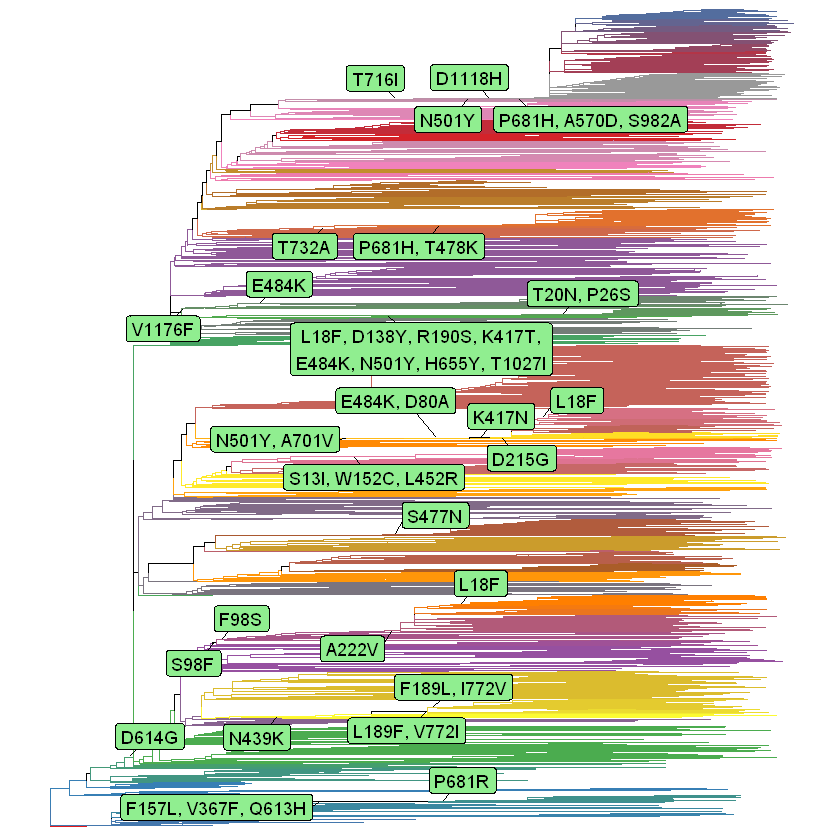

In [12]:
plot(fixed) + ggplot2::theme(legend.position = "none")

In [13]:
paths <- attr(fixed, "paths")

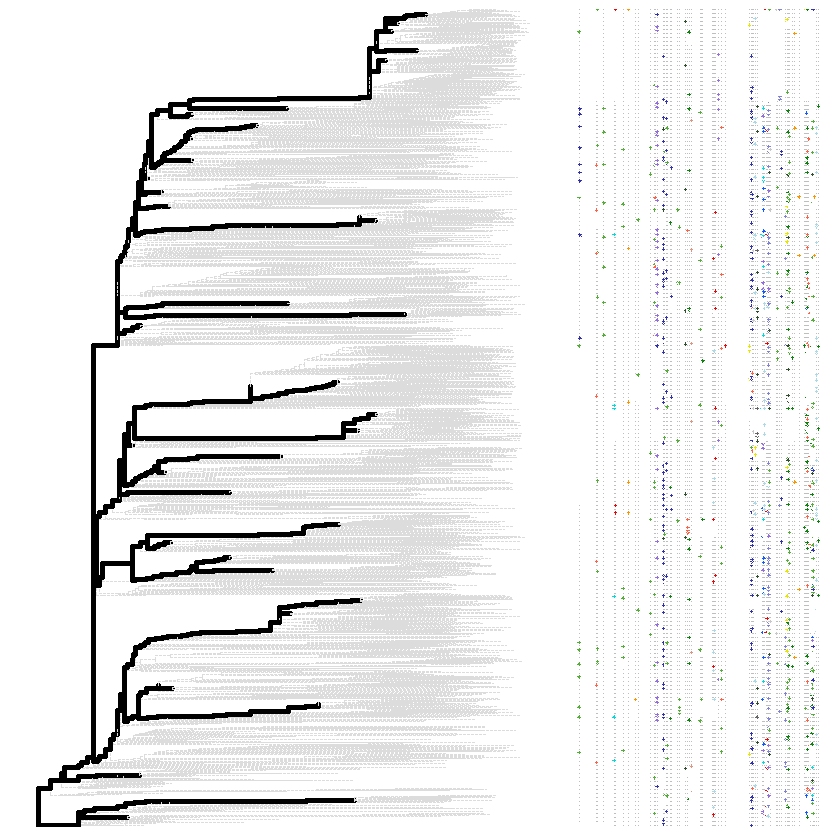

In [14]:
plotMutSites(paths)